In [3]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
import os
from glob import glob
import cv2
import re
import scipy.misc
import imageio
from tqdm import tqdm
import shutil
import pickle

%matplotlib inline


In [2]:
def _plot_log(log_data, model_folder):

    config = log_data['config']
    training_log = np.array(log_data['log'])
    start_step = config['start_step']
    end_step = config['end_step']
    epochs = config['epochs']
    batches_n = config['batches_n']
    batch_size = config['batch_size']
    learning_rate = config['learning_rate']
    dropout = config['dropout']
    eps = config['eps']
    l2_reg = config['l2_reg']
    scale = config['scale']
    
    loss_log = training_log[:, 0]
    acc_log = training_log[:, 1]
    iou_log = training_log[:, 2]

    text = 'Loss: {:.4f}, Acc: {:.4f}, IoU: {:.4f}'.format(loss_log[-1], acc_log[-1], iou_log[-1])

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    c1 = colors[0]
    c2 = colors[1]
    c3 = colors[3]

    fig, ax1 = plt.subplots(figsize=(10, 7))

    ax1.set_xlabel('Epochs (Unit: step)')
    ax1.set_ylabel('Loss/Accuracy')

    x = np.arange(min(start_step + batches_n, end_step), end_step + 1, batches_n)

    # x = np.arange(0, sl)

    
    ax1.plot(x, loss_log, label='Loss', color=c1, marker='.')
    ax1.plot(x, acc_log, label='Accuracy', color=c2, marker='.')
    plt.xticks(x, x, rotation=(0 if len(x) < 20 else 80))

    ax2 = ax1.twinx()
    ax2.plot(x, iou_log, label='IOU', color=c3, marker='s')
    ax2.set_ylabel('IOU')

    handles, labels = ax1.get_legend_handles_labels()
    handles_2, labels_2 = ax2.get_legend_handles_labels()

    handles += handles_2
    labels += labels_2

    fig.legend(handles, labels, loc=(0.7, 0.5))
    fig.tight_layout()

    plt.title("(EP: {}, BS: {}, LR: {}, DO: {}, L2: {}, EPS: {}, S: {})".format(
        epochs, batch_size, learning_rate, dropout, l2_reg, eps, 'ON' if scale else 'OFF'))

    fig.text(0.5, 0, text, verticalalignment='top', horizontalalignment='center', color='black', fontsize=10)
    file_name = 'training_log_' + str(start_step) + '_' + str(end_step) + '.png'
    fig.savefig(os.path.join(model_folder, file_name), bbox_inches='tight')

    fig.show()

C:\Users\Marco\Miniconda3\envs\deeplearning\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


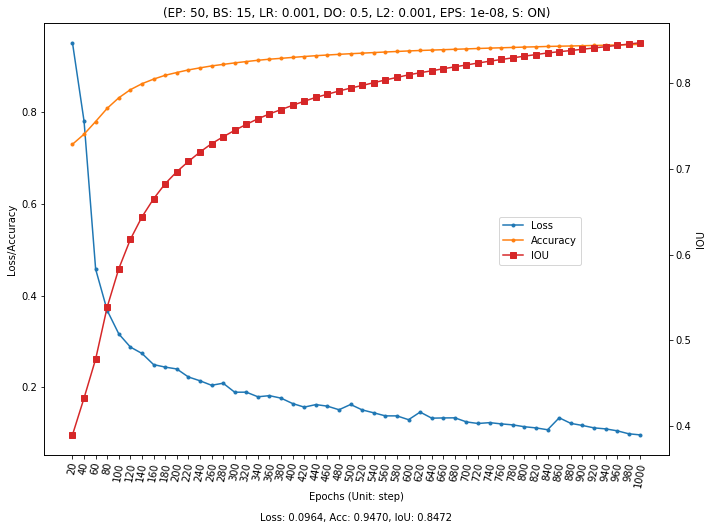

In [3]:
import pickle

model_folder = 'models\\scaling_on'
file_name = 'training_log_0_1000.p'
file_path = os.path.join(model_folder, file_name)

with open(file_path, 'rb') as f:
    training_log = pickle.load(f)
    
_plot_log(training_log, model_folder)

In [48]:


np.random.seed(32)

def apply_random_brightness(img_rgb, brightness_range = (0.6, 1.4)):
    factor = np.random.uniform(brightness_range[0], brightness_range[1])
    
    if abs(factor - 1.0) < 0.09:
        return img_rgb
    
    img_yuv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YUV)
    
    y = img_yuv[:, :, 0]
    y = np.where(y * factor <= 255, y * factor, 255)
    
    adjusted_img = np.copy(img_yuv)
    adjusted_img[:, :, 0] = y
    adjusted_img = cv2.cvtColor(adjusted_img, cv2.COLOR_YUV2RGB)
    
    return adjusted_img

def augment_dataset(dataset_folder='data\\data_road', output='data\\augmented', random_brightness=(0.8, 1.5)):
    data_folder = os.path.join(dataset_folder, 'training')
    
    output_folder = os.path.join(output, os.path.basename(dataset_folder))
    
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    
    output_folder_img = os.path.join(output_folder, os.path.join('training', 'image_2'))
    output_folder_img_labels = os.path.join(output_folder, os.path.join('training', 'gt_image_2'))
    
    os.makedirs(output_folder_img)
    os.makedirs(output_folder_img_labels)
    
    image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))
    
    image_labels = {
        re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
        for path in glob(os.path.join(data_folder, 'gt_image_2', '*_road_*.png'))
    }
    
    for image_file in tqdm(image_paths, desc='Augmenting Dataset', unit='images'):
        img_file_name = os.path.basename(image_file)
        img_label_file = image_labels[img_file_name]
        img_label_file_name = os.path.basename(img_label_file)
        
        img = imageio.imread(image_file)
        img_label = imageio.imread(img_label_file)
        
        img_flipped = np.fliplr(img)
        img_label_flipped = np.fliplr(img_label)
        
        if random_brightness:
            img = apply_random_brightness(img)
            img_flipped = apply_random_brightness(img_flipped)
        
        imageio.imsave(os.path.join(output_folder_img, img_file_name), img)
        imageio.imsave(os.path.join(output_folder_img_labels, img_label_file_name), img_label)
        
        imageio.imsave(os.path.join(output_folder_img, 'flipped_' + img_file_name), img_flipped)
        imageio.imsave(os.path.join(output_folder_img_labels, 'flipped_' + img_label_file_name), img_label_flipped)
        

augment_dataset()

95


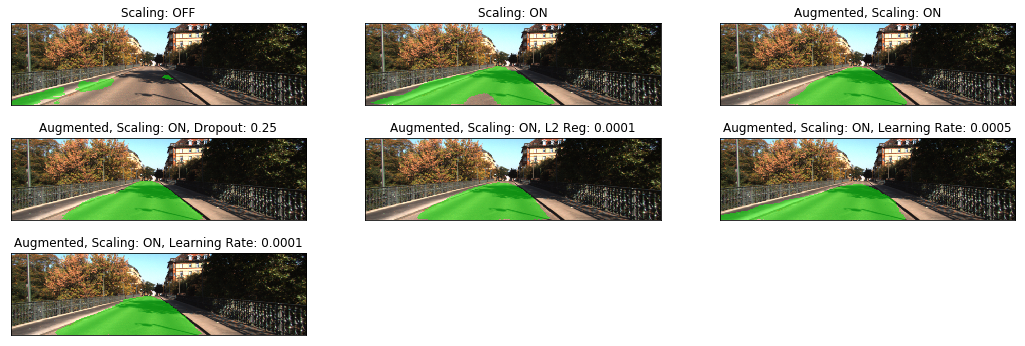

In [73]:
def show_imgs(folder = os.path.join('runs'), 
              runs=['scaling_off', 'scaling_on', 'augmented', 'dropout', 'l2_reg', 'learning_rate', 'learning_rate_2'],
              titles=['Scaling: OFF', 'Scaling: ON', 'Augmented, Scaling: ON', 'Augmented, Scaling: ON, Dropout: 0.25', 'Augmented, Scaling: ON, L2 Reg: 0.0001', 'Augmented, Scaling: ON, Learning Rate: 0.0005', 
                      'Augmented, Scaling: ON, Learning Rate: 0.0001']):
    
    cols = 3
    rows = np.ceil(len(runs) / cols).astype('uint32')
    
    fig = plt.figure(figsize = (18, rows * 2))
    
    
    image_paths = glob(os.path.join(folder, runs[0], '*.png'))
    
    idx = np.random.randint(0, len(image_paths))
    image_name = os.path.basename(image_paths[idx])
    
    for i, run in enumerate(runs):
        plt.subplot(rows, cols, i + 1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        
        img = imageio.imread(os.path.join(folder, run, image_name))
                            
        plt.imshow(img)
        
    file_name = 'tuning.png'
    fig.savefig(os.path.join('images', file_name), bbox_inches='tight')

show_imgs()                            

C:\Users\Marco\Miniconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:56: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
C:\Users\Marco\Miniconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:57: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


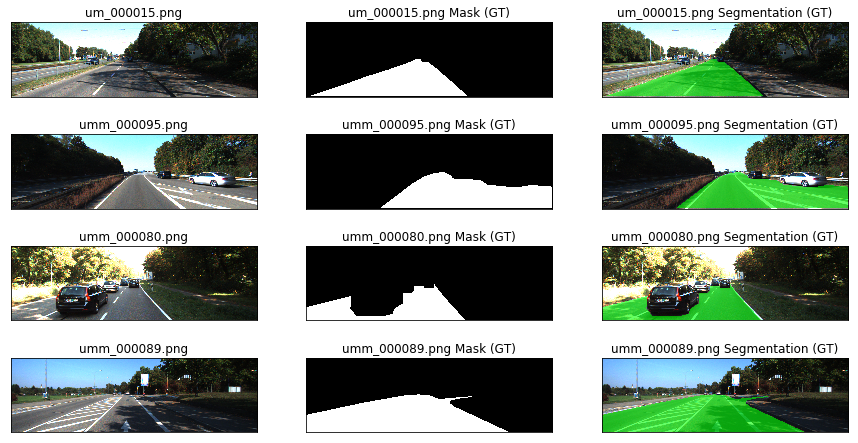

In [62]:
import re

def show_kitti(folder = os.path.join('data', 'data_road', 'training')):
    
    cols = 3
    n = 4
    rows = 3 * np.ceil(n / cols).astype('uint32')
    
    fig = plt.figure(figsize = (15, rows * 2))
    
    image_paths = glob(os.path.join(folder, 'image_2', '*.png'))
    label_paths = {
        re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
        for path in glob(os.path.join(folder, 'gt_image_2', '*_road_*.png'))
    }
    
    background_color = np.array([255, 0, 0])
    
    indices = np.random.randint(0, len(image_paths), n)
    
    i=1
    for idx in indices:
        image_path = image_paths[idx]
        image_label_path = label_paths[os.path.basename(image_path)]
        
        plt.subplot(rows, cols, i)
        i+=1
        
        plt.title(os.path.basename(image_path))
        plt.xticks([])
        plt.yticks([])
        
        img = imageio.imread(image_path)                    
        plt.imshow(img)
        
        plt.subplot(rows, cols, i)
        i+=1
        
        plt.title(os.path.basename(image_path) + ' Mask (GT)')
        plt.xticks([])
        plt.yticks([])
        
        gt_image = imageio.imread(image_label_path)
        plt.imshow(gt_image[:,:,2], cmap="gray")
        
        plt.subplot(rows, cols, i)
        i+=1
        
        plt.title(os.path.basename(image_path) + ' Segmentation (GT)')
        plt.xticks([])
        plt.yticks([])
        
        segmentation = (gt_image[:,:,2] > 0.5).reshape(gt_image.shape[0], gt_image.shape[1], 1)
        # Create mask based on segmentation to apply to original image
        mask = np.dot(segmentation, np.array([[0, 200, 0, 120]]))
        mask = scipy.misc.toimage(mask, mode="RGBA")
        street_im = scipy.misc.toimage(img)
        street_im.paste(mask, box=None, mask=mask)

        plt.imshow(street_im)
        
        
    file_name = 'kitti_dataset.png'
    fig.savefig(os.path.join('images', file_name), bbox_inches='tight')
    
show_kitti()

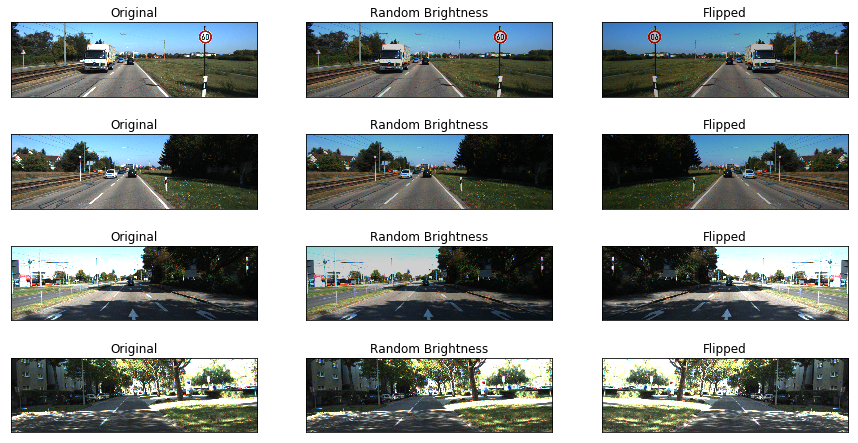

In [82]:
def show_aug(folder = os.path.join('data', 'data_road', 'training')):
    
    cols = 3
    n = 4
    rows = 3 * np.ceil(n / cols).astype('uint32')
    
    fig = plt.figure(figsize = (15, rows * 2))
    
    folder_aug = os.path.join('data', 'augmented', 'data_road', 'training')
    
    image_paths = glob(os.path.join(folder, 'image_2', '*.png'))
    
    indices = np.random.randint(0, len(image_paths), n)
    
    i=1
    for idx in indices:
        image_path = image_paths[idx]
        image_aug_path = os.path.join(folder_aug, 'image_2', os.path.basename(image_path))
        image_flipped_path =  os.path.join(folder_aug, 'image_2', 'flipped_' + os.path.basename(image_path))
        
        plt.subplot(rows, cols, i)
        i+=1
        
        plt.title('Original')
        plt.xticks([])
        plt.yticks([])
        
        img = imageio.imread(image_path)                    
        plt.imshow(img)
        
        plt.subplot(rows, cols, i)
        i+=1
        
        plt.title('Random Brightness')
        plt.xticks([])
        plt.yticks([])
        
        img_aug = imageio.imread(image_aug_path)
        plt.imshow(img_aug)
        
        plt.subplot(rows, cols, i)
        i+=1
        
        plt.title('Flipped')
        plt.xticks([])
        plt.yticks([])

        img_flipped = imageio.imread(image_flipped_path)
        plt.imshow(img_flipped)
        
        
       
        
        
    file_name = 'augmented_dataset.png'
    fig.savefig(os.path.join('images', file_name), bbox_inches='tight')
    
show_aug()